## 5. Állandó fázisú pont módszere, SPPMethod

Ez a módszer alapjaiban kissé különbözik a többitől. Az előzőleg leírt globális metódusok, mint domain átváltás, kivágás, stb. itt is működnek, de másképpen kell kezelni őket. *Megjegyezném, hogy mivel ez a módszer interaktív elemet tartalmaz még Spyderben nem működik konzisztensen, azt javaslom, hogy egyelőre ezt mindenképpen Jupyter Notebook-ban használjuk.*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysprint as ps

Példaként a korábban már bemutatott `ps.Generator` segítségével generálni fogok egy sorozat interferogramot, majd azon bemutatom a kiértékelés menetét. Valós méréseknél teljesen hasonlóképpen végezhető a kiértékelés. A legegyszerűbb módszer, hogy különböző karok közti időbeli késleltetésnél generáljunk és elmentsük azokat az alábbi cellában látható. A megkülönböztethetőség miatt minden fájlt a hozzá tartozó karok közti időbeli késleltetésnek megfelelően nevezem el.

In [3]:
for delay in range(-200, 201, 50):
    g = ps.Generator(1, 3, 2, delay, GDD=400, TOD=-500, normalize=True)
    g.generate_freq()
    np.savetxt(f'{delay}.txt', np.transpose([g.x, g.y]), delimiter=',')

A kód lefuttatásával a munkafüzet környtárában megjelent 7 új txt fájl. 

Ehhez a kiértékelési módszerhez először fel kell építeni egy listát a felhasználandó interferogramok fájlneveivel. Ezt manuálisan is megtehetjük, itt ezt elkerülve egy rövidítést fogok használni.

In [4]:
ifg_files = [f"{delay}.txt" for delay in range(-200, 201, 50)]

In [5]:
print(ifg_files)

['-200.txt', '-150.txt', '-100.txt', '-50.txt', '0.txt', '50.txt', '100.txt', '150.txt', '200.txt']


Ha nem hasonló sémára épülnek a felhasználandó fájlok nevei, akkor természetesen a fenti trükk nem működik és egyenként kell beírnunk őket. Miután definiáltuk a fájlneveket a következő lépés a
```python
ps.SPPMethod(ifg_names, sam_names=None, ref_names=None, **kwargs)
```
meghívása:

In [6]:
myspp = ps.SPPMethod(ifg_files, decimal=".", sep=",", skiprows=0, meta_len=0)

A `**kwargs` keyword argumentumok itt elfogadják a korábban már bemutatott `parse_raw` funkció argumentumait (a kódban belül azt is hívja meg egyesével minden interferogramon), hiszen a fájlok sémáját itt is fontos megadni a helyes betöltéshez. A tárgy- és referencianyaláb spektrumai természetesen opcionális argumentumok, mi dönthetjük el, hogy normáljuk-e az interferogramokat.

Az `SPPMethod` objektum először ellenőrzi, hogy a listában lévő fájlnevek valóban léteznek-e, és ha nem, akkor hibával tér vissza. Az `SPPMethod`-nak vannak további metódusai, ilyen pl. a `len(..)`, vagy az `SPPMethod.info`. Az első visszaadja, hogy hány interferogram van jelenleg az objektumban (ez jelen esetben 7), a második pedig a kiértékelés során mutatja majd, hogy hány interferogramból rögzítettünk információt (ez jelenleg 0/7). Később talán `append`, `insert` és `delete` metódusokat is beépítek.

In [7]:
print(len(myspp))

9


In [8]:
print(myspp.info)

Progress: 0/9


Az SPPMethod objektum listaszerűen viselkedik: lehet indexelni is. Mivel benne 7 darab interferogram van, ezért egy ilyen indexelés egy `ps.Dataset` objektumot ad vissza. Ez az alapja minden kiértékelési módszernek, (pl. az előbbi leírásbeli `ps.CosFitMethod`-nak is) így ez ismeri a korábban bemutatott metódusokat. Tegyük fel, hogy a 3. interferogram adatait ki szeretnénk iratni, és szeretnénk megkapni az y értékeit `np.ndarray`-ként. Ekkor a 2 indexet használva (mivel itt is 0-tól indul a számozás):


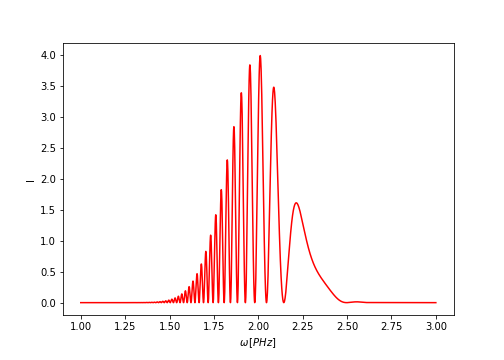

In [10]:
# a harmadik interferogram adatainak kiíratása
myspp[2]

In [11]:
# a harmadik interferogram y értékeinek kinyerése, mint np.array
y_ertekek = myspp[2].data.y.values
print(y_ertekek)
print(type(y_ertekek))

[4.22567237e-08 4.23424876e-08 4.24102757e-08 ... 4.41394357e-08
 4.30227521e-08 4.18888151e-08]
<class 'numpy.ndarray'>


Újra hangsúlyozom, minden eddig bemutatott metódus ezeken a kvázi listaelemeken is működik, köztük a `chdomain`, vagy `slice` is. Ezt használjuk ki a kiértékeléshez egy *for* ciklusban. A kiértékeléshez a definiált `SPPMethod`-on meg kell hívni egy for ciklust. Ez végigfut a benne lévő összes interferogramon. Azt, hogy mit akarunk csinálni adott interferogrammal, azt a cikluson belül tudjuk megadni. Az alapvető séma a következő:
<pre>
for ifg in myspp:
    - előfeldolgozása az adott interferogramnak
    - az interaktív SPP Panel megnyitása
    - <del>a beírt adatok rögzítése</del> (0.12.2 verzióban már nem szükséges)
    
- a calculate metódus meghívása a cikluson kívül(!)
</pre>

Ez kód formájában az alábbi cellában látható. Itt külön jelöltem, hogy melyik rész meddig tart.

In [10]:
# fontos ezt meghívni az interaktív számítások előtt

with ps.interactive():

    for ifg in myspp:

        # -----------------------------------Előfeldolgozás-----------------------------------------
        # Ha valós mérésünk van, érdemes valamilyen módon kiíratni a kommentet,
        # ami az interferogram fájlban van, hogy meg tudjuk állapítani milyen késleltetésnél készült.
        # Jelen esetben ennek nincs értelme, mivel a szimulált fájlokkal dolgozom.
        # Ezt legegyszerűbben az alábbi sorral tehetnénk meg: 
        # print(ifg.meta['comment'])
        # vagy esetleg a teljes metaadatok kiíratása:
        # print(ifg.meta)

        # Ha hullámhossztartományban vagyunk, először át kell váltani.
        # Én frekvenciatartományban szimuláltam, ezért itt kihagyom. Ha szükség van rá a
        # következő sort kell használni.
        # ifg.chdomain() 

        # Pl. 1.2 PHz alatti körfrekvenciaértékek kivágása. Mivel nem adtam meg stop értéket, így a felső
        # határt érintetlenül hagyná, ha futtatnám. Nyilván ez is opcionális.
        # ifg.slice(start=1.2)

        # -----------------------------Az interaktív panel megnyitása-------------------------------
        ifg.open_SPP_panel()

# ---------------------------------A ciklus utáni rész------------------------------------------
# A cikluson kívül a save_data metódus meghívása, hogy elmentsük a beírt adatainkat fájlba is.
# Ez természetesen opcionális, de annak érdekében, hogy ne veszítsünk adatot érdemes ezt is elvégezni.
myspp.save_data('spp.txt')


# a cikluson kívül meghívjuk a calculate függvényt
myspp.calculate(reference_point=2, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Az eddigiek alapján a kiértékelés hosszadalmasnak tűnhet, de ha a magyarázatokat kivesszük, szimulált esetben az egész kód az alábbi, összesen 7 sorra egyszerűsödik. Valós mérés esetén néhány előfeldolgozási lépés és printelés természetesen még hozzáadódik ehhez.

```python
ifg_files = [f"{delay}.txt" for delay in range(-200, 201, 50)]

s = ps.SPPMethod(ifg_files, decimal=".", sep=",", skiprows=0, meta_len=0)

with ps.interactive():
    for ifg in s:
        ifg.open_SPP_panel()
    
s.save_data('spp.txt')
s.calculate(reference_point=2, order=2, show_graph=True)
```

Mivel az `spp.txt` fájlba elmentettük az bevitt adatokat, azokból egyszerűen lehet újraszámolni az illesztést. Töltsük be `np.loadtxt` segítségével, majd használjuk a `ps.SPPMethod.calculate_from_raw` függvényt.

In [11]:
delay, position = np.loadtxt('spp.txt', delimiter=',', unpack=True)

myspp.calculate_from_raw(delay, position, reference_point=2, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Itt látható, hogy ugyan azt az eredményt kaptuk, mint előzőleg. Ez akkor is hasznos lehet, ha már megvannak a leolvasott SPP pozícióink a hozzá tartozó késleltetésekkel és csak a számolást akarjuk elvégezni. Ekkor még létre sem kell hozni egy új objektumot, csak meghívhatjuk a függvényt következő módon:

In [12]:
# ehhez beírtam egy teljesen véletlenszerű adatsort
delay_minta = [-100, 200, 500, 700, 900]
position_minta = [2, 2.1, 2.3, 2.45, 2.6]

ps.SPPMethod.calculate_from_raw(delay_minta, position_minta, reference_point=2, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**FONTOS MEGJEGYZÉS:**

Az `order` argumentum a program során mindig a keresett diszperzió rendjét adja meg.

#### További módszer

Korábban már észrevehettük, hogy a kiíratás során - legyen bármilyen módszerről is szó - megjelentek olyan sorok is, hogy `Delay value: Not given` és `SPP position(s): Not given`. Például a `myspp` első interferogramja esetén:


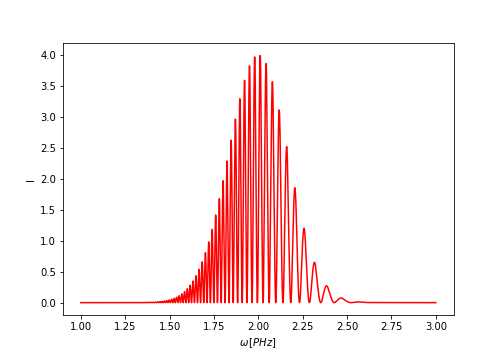

In [13]:
myspp[0]

Ahogyan a `Dataset` leírásában már szerepelt, lehetőségünk van megadni a betöltött interferogramokon az SPP módszerhez szükséges adatokat. Ekkor a `ps.SPPMethod.calculate_from_ifg(ifgs, reference_point, order)` függvénnyel kiértékelhetjük a benne lévő interferogramokat a következő módon:

In [14]:
# kicsomagolok öt interferogramot a generált 7 közül

elso_ifg = myspp[0]
masodik_ifg = myspp[1]
harmadik_ifg = myspp[2]
negyedik_ifg = myspp[3]
otodik_ifg = myspp[4]

In [15]:
# beállítok rájuk véletlenszerűen SPP adatokat

elso_ifg.delay = 0
elso_ifg.positions = 2

masodik_ifg.delay = 100
masodik_ifg.positions = 2

harmadik_ifg.delay = 150
harmadik_ifg.positions = 1.6

negyedik_ifg.delay = 200
negyedik_ifg.positions = 1.2

otodik_ifg.delay = 250
otodik_ifg.positions = 1, 3, 1.2


# listába teszem őket
ifgs = [elso_ifg, masodik_ifg, harmadik_ifg, negyedik_ifg, otodik_ifg]

In [16]:
# meghívom a calculate_from_ifg függvényt
ps.SPPMethod.calculate_from_ifg(ifgs, reference_point=2, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Ez úgy lehet hasznos, hogy amikor más módszerrel több interferogramot is kiértékelünk egymás után, csak rögzítjük az SPP adatokat is, aztán a program ezekből egyenként összegyűjti a szükséges információt a kiértékeléshez, majd abból számol.